In [2]:
import time
import pandas as pd
import psycopg2
import datetime
from tqdm import trange

In [3]:
import matplotlib.pyplot as plt 
import matplotlib as mpl 
# %matplotlib inline 
import platform
from matplotlib import font_manager, rc # plt.rcParams['axes.unicode_minus'] = False 
if platform.system() == 'Darwin': rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': 
    path = "c:/Windows/Fonts/malgun.ttf" 
    font_name = font_manager.FontProperties(fname=path).get_name() 
    rc('font', family=font_name) 
else: 
    print('Unknown system... sorry~~~~')

    # row 생략 없이 출력
pd.set_option('display.max_rows', 1000)
# col 생략 없이 출력
pd.set_option('display.max_columns', 1000)
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2

In [4]:
# DB 연결 부분
uswer = 'dt.intern'
host = '10.80.0.234'
port = '5439'
dbname = 'fnf'
con = psycopg2.connect(dbname='fnf',host='10.80.0.234', port='5439', user = 'dt.intern', password='DTintn0926')
cur = con.cursor()

# 운동화 선택 

In [5]:
# 2019년 - 2020년 / 디스커버리 / SH(운동화) 를 가지고 있는 매장 선택
start = time.time()

total_shop_stock_ori = '''
SELECT vfs.weekkey,vfs.shopkey ,vfs.partkey,vfs.scskey,vfs.brand,vfs.season,vfs.partcode,vfs.color,vfs.siz,vfs.week_takeout_qty,vfs.takeout_qty ,vfs.week_sale_qty ,vfs.sale_qty,vfs.week_sale_amt,vfs.stock_qty ,vfs.sale_amt,prdt.gender 
FROM ax.vw_f_scsshopweek vfs
INNER JOIN ax.vw_d_prdt prdt ON vfs.scskey  = prdt.scskey
WHERE vfs.brand = 'X' AND vfs.weekkey BETWEEN '2019-01-01' AND '2020-12-31' AND prdt.item ='SH'
'''

cur.execute(total_shop_stock_ori)
total_shop_stock_ori = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 68.10473203659058


In [6]:
total_shop_stock_ori = pd.DataFrame(total_shop_stock_ori)
total_shop_stock_ori.columns = ['weekkey','shopkey','partkey','scskey','brand','season','partcode','color','siz','week_takeout_qty','takeout_qty' ,'week_sale_qty' ,'sale_qty','week_sale_amt','stock_qty' ,'sale_amt','gender']

In [7]:
total_shop_stock = total_shop_stock_ori

# 매장 선택

In [8]:
# 국내 / 오프라인 / 아울렛,상설 x / 디스커버리 / 2019년 - 2020년 전 기간 운영한 매장 

start = time.time()

shop_list = '''
SELECT shop_2019.shopkey 
FROM(SELECT *
FROM ax.vw_d_shop vds
WHERE type_ax_zone_nm ='국내' AND  vds.chnl_type_sfdc ='오프라인' AND shop_nm NOT LIKE '%아울렛%' AND shop_type_sfdc NOT LIKE '%상설%'  AND vds.brand = 'X' AND (closedate > '2019-12-31' OR closedate is NULL ) AND opendate < '2019-01-01'
LIMIT 1000) AS shop_2019
INNER JOIN (SELECT *
FROM ax.vw_d_shop vds
WHERE type_ax_zone_nm ='국내' AND  vds.chnl_type_sfdc ='오프라인' AND shop_nm NOT LIKE '%아울렛%' AND shop_type_sfdc NOT LIKE '%상설%' AND vds.brand = 'X' AND (closedate > '2020-12-31' OR closedate is NULL ) AND opendate < '2020-01-01'
) AS shop_2020
ON shop_2019.shopkey =shop_2020.shopkey
'''

cur.execute(shop_list)
shop_list = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 1.695159912109375


In [9]:
shop_list_pd = pd.DataFrame(shop_list)
shop_list_pd.columns = ['shopkey']

In [10]:
len(shop_list_pd['shopkey'].unique())

143

In [11]:
# 매장정보

In [12]:
# 국내 / 오프라인 / 아울렛,상설 x / 디스커버리 / 2019년 - 2020년 전 기간 운영한 매장 

start = time.time()

shop_info = '''
SELECT shopkey ,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
FROM ax.vw_d_shop
WHERE type_ax_zone_nm ='국내' AND chnl_type_sfdc='오프라인'
;
'''

cur.execute(shop_info)
shop_info = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 1.3897066116333008


In [13]:
shop_info_pd = pd.DataFrame(shop_info)
shop_info_pd.columns = ['shopkey' ,'shop_nm','shop_nm_sfdc','repr_shopcode','type_shop_nm','type_contract_nm','type_zone_nm','region_nm']

## 매장 선택 및 연도별 분리

In [14]:
total_shop_stock1920 = total_shop_stock[total_shop_stock['weekkey']> datetime.date(2018,12,31) ]

In [219]:
total_shop_stock1920

,weekkey,shopkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender
0,2019-04-15,X10065,X18FDKSH64841,X18FDKSH64841GR190,X,18F,DKSH64841,GR,190,0,1,1,1,55300.00,0,55300.00,X
1,2019-04-15,X10065,X18FDKSH64841,X18FDKSH64841GR200,X,18F,DKSH64841,GR,200,1,3,1,1,55300.00,2,55300.00,X
2,2020-01-13,X10065,X18FDKSH64841,X18FDKSH64841MG210,X,18F,DKSH64841,MG,210,0,8,2,5,63200.00,3,181700.00,X
3,2020-03-09,X10065,X18FDKSH64841,X18FDKSH64841MG210,X,18F,DKSH64841,MG,210,-1,5,0,5,0.00,0,181700.00,X
4,2019-02-11,X10003,X18FDXSH09841,X18FDXSH09841WH250,X,18F,DXSH09841,WH,250,1,1,0,1,0.00,0,90300.00,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375435,2020-11-23,X10056,X21SDXSH7D111,X21SDXSH7D111BE250,X,21S,DXSH7D111,BE,250,1,1,0,0,0.00,1,0.00,X
2375436,2020-11-23,X10056,X21SDXSH7E111,X21SDXSH7E111YE230,X,21S,DXSH7E111,YE,230,1,1,0,0,0.00,1,0.00,X
2375437,2020-11-23,X10056,X21SDXSH7E111,X21SDXSH7E111YE240,X,21S,DXSH7E111,YE,240,1,1,0,0,0.00,1,0.00,X
2375438,2020-11-23,X10056,X21SDXSH7E111,X21SDXSH7E111YE260,X,21S,DXSH7E111,YE,260,1,1,0,0,0.00,1,0.00,X


In [15]:
df_INNER_JOIN = pd.merge(shop_list_pd, total_shop_stock1920, left_on='shopkey', right_on='shopkey', how='inner')

In [16]:
shop_stock_2019 = df_INNER_JOIN[df_INNER_JOIN['weekkey']< datetime.date(2020,1,1) ]
shop_stock_2020 = df_INNER_JOIN[df_INNER_JOIN['weekkey']> datetime.date(2019,12,31) ]

In [17]:
# 전체 날짜별 사이즈 확인
stock_2019 = shop_stock_2019.groupby(['weekkey','siz']).sum()
stock_2020 = shop_stock_2020.groupby(['weekkey','siz']).sum()


# stock_2020 = shop_stock_2020.groupby(['weekkey','color']).sum()

In [18]:
stock_df_2019 = stock_2019.reset_index()
stock_df_2020 = stock_2020.reset_index()

In [19]:
siz_list_2019 = sorted(stock_df_2019['siz'].unique())
siz_list_2020 = sorted(stock_df_2020['siz'].unique())

In [20]:
main_siz_list = ['225','230','240','250','260','270','280','290']

225


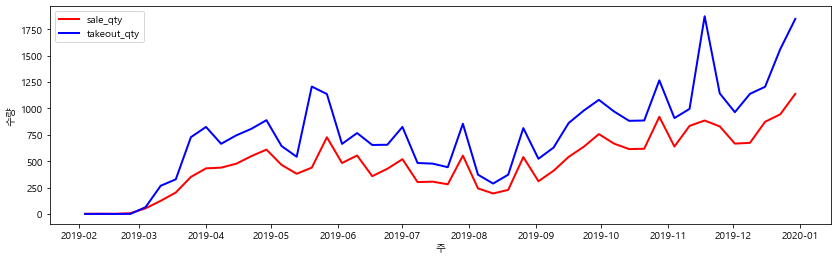

230


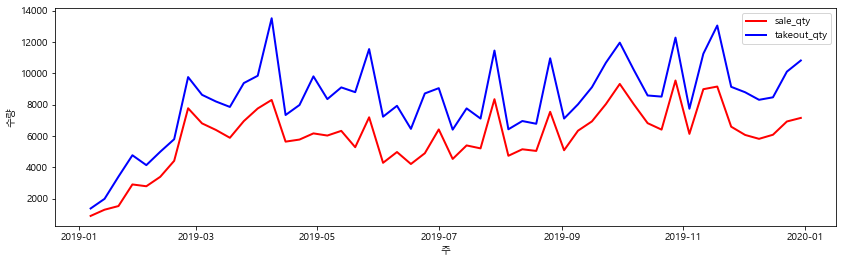

240


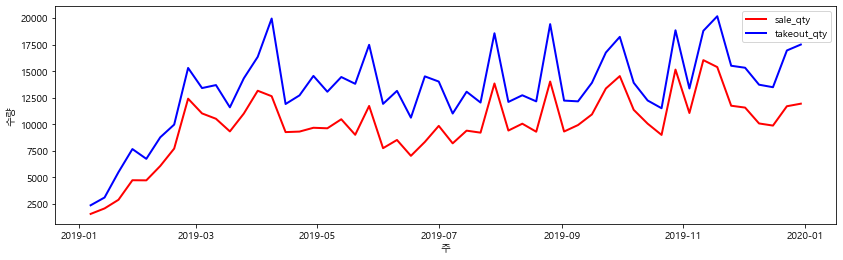

250


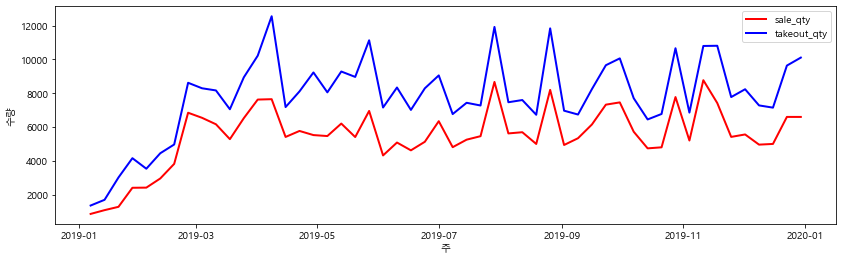

260


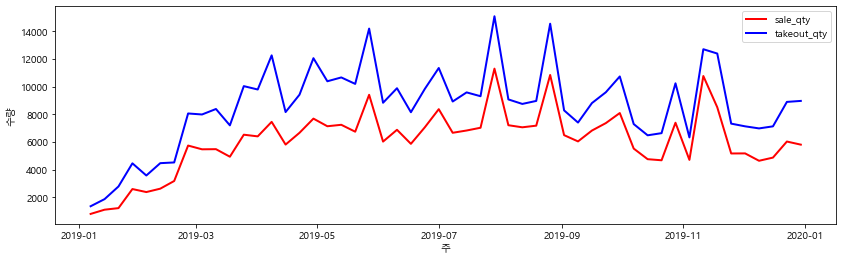

270


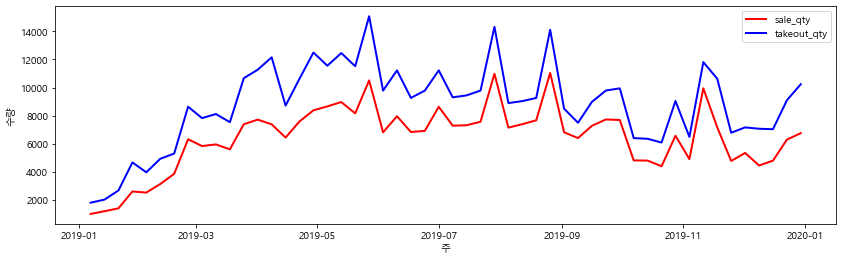

280


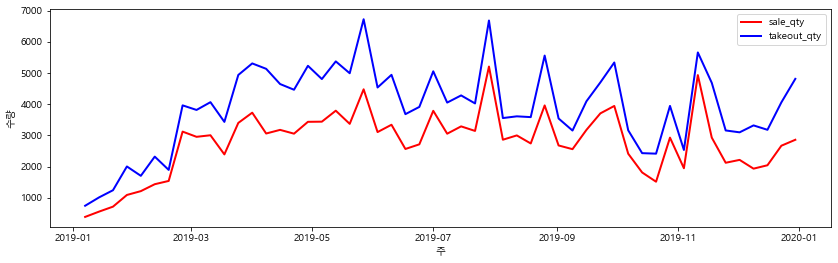

290


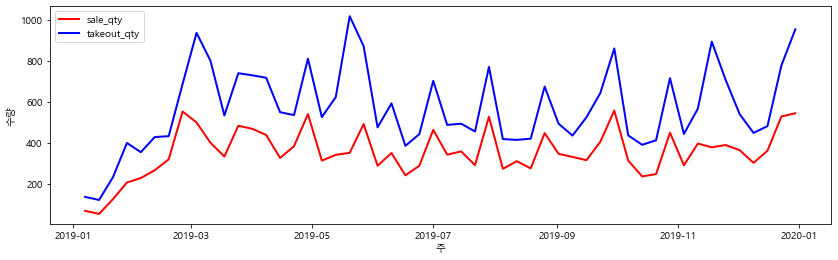

In [21]:
# 사이즈별 총 재고와 총 판매 그래프 
for i in main_siz_list:
    print(i)
    plt.plot(stock_df_2019[stock_df_2019['siz']==i]['weekkey'], stock_df_2019[stock_df_2019['siz']==i]['sale_qty'],'r')
    plt.plot(stock_df_2019[stock_df_2019['siz']==i]['weekkey'], stock_df_2019[stock_df_2019['siz']==i]['takeout_qty'],'b')
    plt.legend(['sale_qty','takeout_qty'])
    plt.xlabel('주')
    plt.ylabel('수량')
    plt.show()

In [326]:
stock_2019.corr()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
week_takeout_qty,1.000000,0.426671,0.475673,0.369910,0.491353
takeout_qty,0.426671,1.000000,0.688431,0.981523,0.768592
week_sale_qty,0.475673,0.688431,1.000000,0.707044,0.424361
sale_qty,0.369910,0.981523,0.707044,1.000000,0.631981
stock_qty,0.491353,0.768592,0.424361,0.631981,1.000000


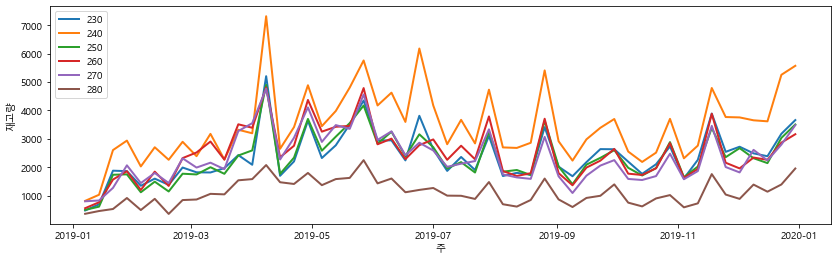

In [23]:
# 재고량
plt.plot(stock_df_2019[stock_df_2019['siz']=='230']['weekkey'], stock_df_2019[stock_df_2019['siz']=='230']['stock_qty'],label='230')
plt.plot(stock_df_2019[stock_df_2019['siz']=='240']['weekkey'], stock_df_2019[stock_df_2019['siz']=='240']['stock_qty'],label='240')
plt.plot(stock_df_2019[stock_df_2019['siz']=='250']['weekkey'], stock_df_2019[stock_df_2019['siz']=='250']['stock_qty'],label='250')
plt.plot(stock_df_2019[stock_df_2019['siz']=='260']['weekkey'], stock_df_2019[stock_df_2019['siz']=='260']['stock_qty'],label='260')
plt.plot(stock_df_2019[stock_df_2019['siz']=='270']['weekkey'], stock_df_2019[stock_df_2019['siz']=='270']['stock_qty'],label='270')
plt.plot(stock_df_2019[stock_df_2019['siz']=='280']['weekkey'], stock_df_2019[stock_df_2019['siz']=='280']['stock_qty'],label='280')
plt.legend([230,240,250,260,270,280])
plt.xlabel('주')
plt.ylabel('재고량')
plt.show()

In [24]:
stock_df_sum_2019 = stock_df_2019.groupby(['weekkey']).sum()

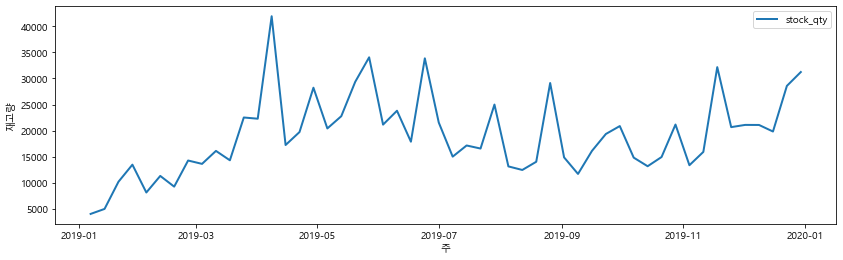

In [25]:
# 재고량
plt.plot(stock_df_sum_2019.index, stock_df_sum_2019['stock_qty'])
plt.legend(['stock_qty'])
plt.xlabel('주')
plt.ylabel('재고량')
plt.show()

# 2019/2020 비교 

In [26]:
stock_2019 = shop_stock_2019.groupby(['weekkey','shopkey',]).sum()
stock_2020 = shop_stock_2020.groupby(['weekkey','shopkey']).sum()

In [27]:
stock_2019 = stock_2019.reset_index()
stock_2020 = stock_2020.reset_index()

In [28]:
shop_key_list = stock_2020['shopkey'].unique()

In [29]:
stock_sum_2019 = []
stock_sum_2020 = []
stock_plus_2019 = []
stock_takeout_2019 = []
stock_takeout_2020 = []
stock_sale_2019 = []
stock_sale_2020 = []
stock_ratio_2019=[]
stock_ratio_2020=[]
sale_takeout_2019=[]
sale_takeout_2020=[]

for i in shop_key_list:
    stock_sale_2019.append(stock_2019[stock_2019['shopkey']==i]['week_sale_qty'].sum())
    stock_plus_2019.append( round(stock_2019[stock_2019['shopkey']==i]['week_sale_qty'].sum()*1.2))
    stock_sale_2020.append(stock_2020[stock_2020['shopkey']==i]['week_sale_qty'].sum())
    stock_takeout_2019.append(stock_2019[stock_2019['shopkey']==i]['week_takeout_qty'].sum())
    stock_takeout_2020.append(stock_2020[stock_2020['shopkey']==i]['week_takeout_qty'].sum())
#     stock_sale_2019.append(stock_2019[stock_2019['shopkey']==i]['sale_qty'].sum())
#     stock_sale_2020.append(stock_2020[stock_2020['shopkey']==i]['sale_qty'].sum())
    stock_ratio_2019.append(stock_2019[stock_2019['shopkey']==i].sum()['stock_qty'] / stock_2019[stock_2019['shopkey']==i].sum()['takeout_qty'])
    stock_ratio_2020.append(stock_2020[stock_2020['shopkey']==i].sum()['stock_qty'] / stock_2020[stock_2020['shopkey']==i].sum()['takeout_qty'])
    sale_takeout_2019.append(stock_2019[stock_2019['shopkey']==i].sum()['week_sale_qty'] / stock_2019[stock_2019['shopkey']==i].sum()['week_takeout_qty'])
    sale_takeout_2020.append(stock_2020[stock_2020['shopkey']==i].sum()['week_sale_qty'] / stock_2020[stock_2020['shopkey']==i].sum()['week_takeout_qty'])

#     stock_ratio_2019.append( stock_2019[stock_2019['shopkey']==i]['week_sale_qty'].sum()/ )
#     stock_ratio_2020.append()
#     break
    

In [30]:
df = pd.DataFrame(
                {'shopkey' : shop_key_list,
                 '주 별 총 판매량(2019)' : stock_sale_2019,
                '주 별 총 판매량(2020)' : stock_sale_2020,
                '주 별 총 입고량(2019)':stock_takeout_2019,
                 '주 별 총 입고량(2020)':stock_takeout_2020,
#                  'stock_plus_2019' : stock_plus_2019,
#                  'stock_takeout_2020':stock_takeout_2020,
#                  'stock_sale_2020':stock_sale_2020,
#                  '2019_재고비율':stock_ratio_2019,
#                  '2020_재고비율':stock_ratio_2020,
#                  '2019_판매_입고 비율':sale_takeout_2019,
#                  '2020_판매_입고 비율':sale_takeout_2020
                },
                )

df

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020)
0,X10003,2312,3816,2590,4162
1,X10004,4745,4013,5149,4109
2,X10005,2123,2429,2514,2525
3,X10006,4603,8136,5232,8130
4,X10007,4426,6249,4864,6353
5,X10008,8846,5640,9540,5574
6,X10009,5645,4432,6395,4399
7,X10011,3986,3326,4497,3417
8,X10014,2882,3619,3456,3604
9,X10015,1554,2220,1724,2556


In [31]:
df['판매수량 비율(20/19)'] = df['주 별 총 판매량(2020)'] / df['주 별 총 판매량(2019)']

In [32]:
df['입고수량 비율(20/19)'] = df['주 별 총 입고량(2020)'] / df['주 별 총 입고량(2019)']

In [33]:
df

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19)
0,X10003,2312,3816,2590,4162,1.650519,1.606950
1,X10004,4745,4013,5149,4109,0.845732,0.798019
2,X10005,2123,2429,2514,2525,1.144136,1.004375
3,X10006,4603,8136,5232,8130,1.767543,1.553899
4,X10007,4426,6249,4864,6353,1.411884,1.306127
5,X10008,8846,5640,9540,5574,0.637576,0.584277
6,X10009,5645,4432,6395,4399,0.785120,0.687881
7,X10011,3986,3326,4497,3417,0.834420,0.759840
8,X10014,2882,3619,3456,3604,1.255725,1.042824
9,X10015,1554,2220,1724,2556,1.428571,1.482599


In [34]:
# stock_qty가 0인 경우 / 물건을 판매한 횟수 (이 경우는 물건이 없어서 못팔 확률이 높은 경우이다.)
week_zero_2019=[]
week_up_2019=[]
week_zero_2020=[]
week_up_2020=[]
for i in shop_key_list:
    week_zero_2019.append( shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['stock_qty']==0)].count()[0] / shop_stock_2019[(shop_stock_2019['shopkey']==i)].count()[0])

    week_zero_2020.append( shop_stock_2020[(shop_stock_2020['shopkey']==i) & (shop_stock_2020['stock_qty']==0)].count()[0] /shop_stock_2020[(shop_stock_2020['shopkey']==i)].count()[0])


In [35]:
df2 = pd.DataFrame(
                {'shopkey' : shop_key_list,
                '매장 내 재고가 0 인 경우(2019)' : week_zero_2019,
                 '매장 내 재고가 0 인 경우(2020)' : week_zero_2020,
                },
                )

In [36]:
df3 = pd.merge(df,df2,on='shopkey',how="inner")

In [248]:
df3.sort_values('판매수량 비율(20/19)',ascending=False)

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020)
55,X10070,2797,7052,3201,7344,2.521273,2.294283,0.269538,0.221719
43,X10057,2769,5795,3571,5584,2.092813,1.563708,0.273630,0.295598
50,X10064,3424,6923,3920,7318,2.021904,1.866837,0.301368,0.216508
37,X10050,5722,11534,6405,12274,2.015729,1.916315,0.232193,0.186933
93,X50057,745,1434,1076,1476,1.924832,1.371747,0.298601,0.283711
36,X10048,1365,2612,1577,2832,1.913553,1.795815,0.388487,0.267570
42,X10056,1461,2702,1647,2840,1.849418,1.724347,0.353178,0.305859
92,X50055,657,1170,816,1285,1.780822,1.574755,0.327575,0.300230
19,X10027,2909,5178,3720,5150,1.779993,1.384409,0.291751,0.269544
3,X10006,4603,8136,5232,8130,1.767543,1.553899,0.291137,0.243843


In [38]:
df3.corr()

,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020)
주 별 총 판매량(2019),1.000000,0.801187,0.994896,0.788359,-0.289030,-0.358750,-0.436707,-0.478604
주 별 총 판매량(2020),0.801187,1.000000,0.811281,0.997795,0.258534,0.150248,-0.439028,-0.515850
주 별 총 입고량(2019),0.994896,0.811281,1.000000,0.797551,-0.267303,-0.367163,-0.437017,-0.457993
주 별 총 입고량(2020),0.788359,0.997795,0.797551,1.000000,0.271901,0.175286,-0.441386,-0.528889
판매수량 비율(20/19),-0.289030,0.258534,-0.267303,0.271901,1.000000,0.922037,0.114445,-0.004173
입고수량 비율(20/19),-0.358750,0.150248,-0.367163,0.175286,0.922037,1.000000,0.185506,-0.014546
매장 내 재고가 0 인 경우(2019),-0.436707,-0.439028,-0.437017,-0.441386,0.114445,0.185506,1.000000,0.713037
매장 내 재고가 0 인 경우(2020),-0.478604,-0.515850,-0.457993,-0.528889,-0.004173,-0.014546,0.713037,1.000000


In [249]:
df4=df3.sort_values('판매수량 비율(20/19)',ascending=False)
df4

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020)
55,X10070,2797,7052,3201,7344,2.521273,2.294283,0.269538,0.221719
43,X10057,2769,5795,3571,5584,2.092813,1.563708,0.273630,0.295598
50,X10064,3424,6923,3920,7318,2.021904,1.866837,0.301368,0.216508
37,X10050,5722,11534,6405,12274,2.015729,1.916315,0.232193,0.186933
93,X50057,745,1434,1076,1476,1.924832,1.371747,0.298601,0.283711
36,X10048,1365,2612,1577,2832,1.913553,1.795815,0.388487,0.267570
42,X10056,1461,2702,1647,2840,1.849418,1.724347,0.353178,0.305859
92,X50055,657,1170,816,1285,1.780822,1.574755,0.327575,0.300230
19,X10027,2909,5178,3720,5150,1.779993,1.384409,0.291751,0.269544
3,X10006,4603,8136,5232,8130,1.767543,1.553899,0.291137,0.243843


In [255]:
df_shop = pd.merge(df4, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
df_shop

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020),shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,X10070,2797,7052,3201,7344,2.521273,2.294283,0.269538,0.221719,신세계강남,디스커버리 신세계 강남점,XH0260,일반매장,백화점특정,백화점,서울
1,X10057,2769,5795,3571,5584,2.092813,1.563708,0.273630,0.295598,현대목동,디스커버리 현대 목동점,XH0014,일반매장,백화점특정,백화점,서울
2,X10064,3424,6923,3920,7318,2.021904,1.866837,0.301368,0.216508,현대천호,디스커버리 현대 천호점,XH0253,일반매장,백화점특정,백화점,서울
3,X10050,5722,11534,6405,12274,2.015729,1.916315,0.232193,0.186933,롯데본점,디스커버리 롯데 본점,XH0248,일반매장,백화점특정,백화점,서울
4,X50057,745,1434,1076,1476,1.924832,1.371747,0.298601,0.283711,여천(대-위),디스커버리 여천점,XH0061,일반매장,대리점,대리점,전남
5,X10048,1365,2612,1577,2832,1.913553,1.795815,0.388487,0.267570,아이파크용산,디스커버리 아이파크 용산점,XH0243,일반매장,백화점특정,백화점,서울
6,X10056,1461,2702,1647,2840,1.849418,1.724347,0.353178,0.305859,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
7,X50055,657,1170,816,1285,1.780822,1.574755,0.327575,0.300230,창원중앙(대-위),디스커버리 창원중앙점,XH0057,일반매장,대리점,대리점,경남
8,X10027,2909,5178,3720,5150,1.779993,1.384409,0.291751,0.269544,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
9,X10006,4603,8136,5232,8130,1.767543,1.553899,0.291137,0.243843,AK분당,디스커버리 AK 분당점,XH0100,일반매장,백화점특정,백화점,경기


In [262]:
df_shop_15 = df_shop[df_shop['판매수량 비율(20/19)']>1.5]
df_shop_15

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020),shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,X10070,2797,7052,3201,7344,2.521273,2.294283,0.269538,0.221719,신세계강남,디스커버리 신세계 강남점,XH0260,일반매장,백화점특정,백화점,서울
1,X10057,2769,5795,3571,5584,2.092813,1.563708,0.273630,0.295598,현대목동,디스커버리 현대 목동점,XH0014,일반매장,백화점특정,백화점,서울
2,X10064,3424,6923,3920,7318,2.021904,1.866837,0.301368,0.216508,현대천호,디스커버리 현대 천호점,XH0253,일반매장,백화점특정,백화점,서울
3,X10050,5722,11534,6405,12274,2.015729,1.916315,0.232193,0.186933,롯데본점,디스커버리 롯데 본점,XH0248,일반매장,백화점특정,백화점,서울
4,X50057,745,1434,1076,1476,1.924832,1.371747,0.298601,0.283711,여천(대-위),디스커버리 여천점,XH0061,일반매장,대리점,대리점,전남
5,X10048,1365,2612,1577,2832,1.913553,1.795815,0.388487,0.267570,아이파크용산,디스커버리 아이파크 용산점,XH0243,일반매장,백화점특정,백화점,서울
6,X10056,1461,2702,1647,2840,1.849418,1.724347,0.353178,0.305859,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
7,X50055,657,1170,816,1285,1.780822,1.574755,0.327575,0.300230,창원중앙(대-위),디스커버리 창원중앙점,XH0057,일반매장,대리점,대리점,경남
8,X10027,2909,5178,3720,5150,1.779993,1.384409,0.291751,0.269544,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
9,X10006,4603,8136,5232,8130,1.767543,1.553899,0.291137,0.243843,AK분당,디스커버리 AK 분당점,XH0100,일반매장,백화점특정,백화점,경기


In [260]:
df_type_zone_nm= df_shop_15.iloc[0:].groupby('type_zone_nm').count()[['shopkey']].reset_index()
df_type_zone_nm.columns = ['type_zone_nm','count']

In [261]:
df_type_zone_nm

,type_zone_nm,count
0,대리점,16
1,백화점,10


In [269]:
df_region_nm = df_shop_15.iloc[0:].groupby('region_nm').count()[['shopkey']].reset_index()
df_region_nm.columns = ['region_nm','count']
df_region_nm

,region_nm,count
0,강원,1
1,경기,7
2,경남,2
3,경북,1
4,광주,2
5,부산,1
6,서울,5
7,울산,1
8,인천,1
9,전남,4


In [295]:
ratio_list_2019=[]
for i in df4['shopkey']:
    ratio_list_2019.append((shop_stock_2019[shop_stock_2019['shopkey']==i].groupby(['weekkey']).sum()['sale_qty'] / shop_stock_2019[shop_stock_2019['shopkey']==i].groupby(['weekkey']).sum()['takeout_qty']).mean())

In [296]:
ratio_list_2020=[]
for i in df4['shopkey']:
    ratio_list_2020.append((shop_stock_2020[shop_stock_2020['shopkey']==i].groupby(['weekkey']).sum()['sale_qty'] / shop_stock_2020[shop_stock_2020['shopkey']==i].groupby(['weekkey']).sum()['takeout_qty']).mean())

In [299]:
total_ratio_list = []
for i in range(0,len(ratio_list_2020)):
    total_ratio_list.append(ratio_list_2020[i] - ratio_list_2019[i])

In [323]:
sum(ratio_list_2019[0:30])/30

0.622782335723599

In [308]:
sum(total_ratio_list[-1:-10])/10

0.0

In [325]:
sum(ratio_list_2019[len(ratio_list_2019)-30:])/30

0.685845489668136

In [275]:
shop_X10070 = shop_stock_2019[shop_stock_2019['shopkey']=='X10070'].groupby(['weekkey']).sum()
shop_X10070

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
weekkey,,,,,
2019-01-07,6,34,11,22,12
2019-01-14,21,59,22,36,23
2019-01-21,76,118,21,46,72
2019-01-28,34,110,22,71,39
2019-02-04,42,113,40,85,28
2019-02-11,48,155,31,111,44
2019-02-18,59,183,46,152,31
2019-02-25,62,367,61,278,89
2019-03-04,88,355,39,253,102


In [278]:
(shop_stock_2019[shop_stock_2019['shopkey']=='X10070'].groupby(['weekkey']).sum()['sale_qty'] / shop_stock_2019[shop_stock_2019['shopkey']=='X10070'].groupby(['weekkey']).sum()['takeout_qty']).mean()

0.7215797948962338

In [279]:
(shop_X10070['sale_qty'] / shop_X10070['takeout_qty']).mean()

0.7215797948962338

In [282]:
(shop_stock_2019[shop_stock_2019['shopkey']=='X10070'].groupby(['weekkey']).sum()['sale_qty'] / shop_stock_2019[shop_stock_2019['shopkey']=='X10070'].groupby(['weekkey']).sum()['takeout_qty']).mean()

0.7215797948962338

# 재고가 0 인 매장 탐색

In [39]:
# 매장에 따른 재고 0 인 횟수
stock_zero_2019 = shop_stock_2019[shop_stock_2019['stock_qty']==0].groupby(['shopkey']).count()[['weekkey']]
stock_zero_2020 = shop_stock_2020[shop_stock_2020['stock_qty']==0].groupby(['shopkey']).count()[['weekkey']]

In [40]:
stock_zero_2019 = stock_zero_2019.reset_index()
stock_zero_2019.columns=['shopkey','count']
stock_zero_2020 = stock_zero_2020.reset_index()
stock_zero_2020.columns=['shopkey','count']

In [41]:
stock_zero_2019 = stock_zero_2019.sort_values('count',ascending=False)
stock_zero_2020 = stock_zero_2020.sort_values('count',ascending=False)

In [42]:
shop_join_2019 = pd.merge(stock_zero_2019, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
shop_join_2020 = pd.merge(stock_zero_2020, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')

In [43]:
shop_join_2019

,shopkey,count,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,X10009,2848,현대신촌,디스커버리 현대 신촌점,XH0015,일반매장,백화점특정,백화점,서울
1,X10033,2733,현대중동,디스커버리 현대 중동점,XH0228,일반매장,백화점특정,백화점,경기
2,X10080,2716,엔터6왕십리,디스커버리 엔터식스 왕십리점,XH0266,일반매장,백화점특정,백화점,서울
3,X10082,2673,LF스퀘어광양,디스커버리 LF스퀘어 광양점,XH0097,일반매장,백화점특정,백화점,전남
4,X10007,2051,롯데부산,디스커버리 롯데 부산점,XH0203,일반매장,백화점특정,백화점,부산
5,X10004,1993,롯데영등포,디스커버리 롯데 영등포점,XH0204,일반매장,백화점특정,백화점,서울
6,X10008,1963,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울
7,X10043,1940,롯데울산,디스커버리 롯데 울산점,XH0235,일반매장,백화점특정,백화점,울산
8,X10006,1925,AK분당,디스커버리 AK 분당점,XH0100,일반매장,백화점특정,백화점,경기
9,X10014,1908,롯데중동,디스커버리 롯데 중동점,XH0210,일반매장,백화점특정,백화점,경기


In [44]:
shop_join_2020

,shopkey,count,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,X10027,2910,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
1,X10006,2683,AK분당,디스커버리 AK 분당점,XH0100,일반매장,백화점특정,백화점,경기
2,X10057,2666,현대목동,디스커버리 현대 목동점,XH0014,일반매장,백화점특정,백화점,서울
3,X10033,2619,현대중동,디스커버리 현대 중동점,XH0228,일반매장,백화점특정,백화점,경기
4,X10009,2483,현대신촌,디스커버리 현대 신촌점,XH0015,일반매장,백화점특정,백화점,서울
5,X10014,2274,롯데중동,디스커버리 롯데 중동점,XH0210,일반매장,백화점특정,백화점,경기
6,X10007,2252,롯데부산,디스커버리 롯데 부산점,XH0203,일반매장,백화점특정,백화점,부산
7,X10053,2123,신세계경기,디스커버리 신세계 경기점,XH0246,일반매장,백화점특정,백화점,경기
8,X10064,2088,현대천호,디스커버리 현대 천호점,XH0253,일반매장,백화점특정,백화점,서울
9,X10043,2012,롯데울산,디스커버리 롯데 울산점,XH0235,일반매장,백화점특정,백화점,울산


In [45]:
type_zone_nm_2019 = shop_join_2019.iloc[0:].groupby('type_zone_nm').count()[['shopkey']].reset_index()
type_zone_nm_2019.columns = ['type_zone_nm','count(2019)']

In [46]:
type_zone_nm_2020 = shop_join_2020.iloc[0:].groupby('type_zone_nm').count()[['shopkey']].reset_index()
type_zone_nm_2020.columns = ['type_zone_nm','count(2020)']

In [47]:
pd.merge(type_zone_nm_2019,type_zone_nm_2020,on='type_zone_nm',how="outer")

,type_zone_nm,count(2019),count(2020)
0,대리점,70,70
1,백화점,67,67
2,직영점,6,6


In [48]:
type_zone_nm_2019 = shop_join_2019.iloc[0:50].groupby('type_zone_nm').count()[['shopkey']].reset_index()
type_zone_nm_2019.columns = ['type_zone_nm','count(2019)']
type_zone_nm_2020 = shop_join_2020.iloc[0:50].groupby('type_zone_nm').count()[['shopkey']].reset_index()
type_zone_nm_2020.columns = ['type_zone_nm','count(2020)']

In [49]:
type_zone_nm_50 = pd.merge(type_zone_nm_2019,type_zone_nm_2020,on='type_zone_nm',how="outer")
type_zone_nm_50

,type_zone_nm,count(2019),count(2020)
0,대리점,12,7
1,백화점,36,41
2,직영점,2,2


In [52]:
region_nm_2019 = shop_join_2019.iloc[0:50].groupby('region_nm').count()[['shopkey']].reset_index()
region_nm_2019.columns = ['region_nm','count(2019)']
region_nm_2020 = shop_join_2020.iloc[0:50].groupby('region_nm').count()[['shopkey']].reset_index()
region_nm_2020.columns = ['region_nm','count(2020)']

In [53]:
region_nm_50 = pd.merge(region_nm_2019,region_nm_2020,on='region_nm',how="outer")
region_nm_50

,region_nm,count(2019),count(2020)
0,경기,15.0,18.0
1,경남,1.0,1.0
2,경북,1.0,NaN
3,광주,3.0,2.0
4,대구,2.0,2.0
5,대전,3.0,1.0
6,부산,4.0,5.0
7,서울,13.0,14.0
8,울산,2.0,3.0
9,인천,1.0,NaN


In [54]:
region_nm_2019 = shop_join_2019.iloc[0:10].groupby('region_nm').count()[['shopkey']].reset_index()
region_nm_2019.columns = ['region_nm','count(2019)']
region_nm_2020 = shop_join_2020.iloc[0:10].groupby('region_nm').count()[['shopkey']].reset_index()
region_nm_2020.columns = ['region_nm','count(2020)']

In [55]:
region_nm_10 = pd.merge(region_nm_2019,region_nm_2020,on='region_nm',how="outer")
region_nm_10

,region_nm,count(2019),count(2020)
0,경기,3,5.0
1,부산,1,1.0
2,서울,4,3.0
3,울산,1,1.0
4,전남,1,NaN


In [229]:
unique_shop_key = shop_stock_2019[shop_stock_2019['scskey']=='X19SDXSH09911BE240']['shopkey'].unique()

In [232]:
for i in unique_shop_key:
    shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['scskey']=='X19SDXSH09911BE240') ].max() 
    break

In [239]:
shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['scskey']=='X19SDXSH09911BE240') ]['sale_qty'].max()

12

In [242]:
shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['scskey']=='X19SDXSH09911BE240') ].sort_values('weekkey')

,shopkey,weekkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender
6860,X10052,2019-01-14,X19SDXSH09911,X19SDXSH09911BE240,X,19S,DXSH09911,BE,240,2,3,3,3,387000.00,0,387000.00,X
6861,X10052,2019-01-21,X19SDXSH09911,X19SDXSH09911BE240,X,19S,DXSH09911,BE,240,2,5,1,4,129000.00,1,516000.00,X
6862,X10052,2019-01-28,X19SDXSH09911,X19SDXSH09911BE240,X,19S,DXSH09911,BE,240,-1,4,0,4,0.00,0,516000.00,X
4468,X10052,2019-02-04,X19SDXSH09911,X19SDXSH09911BE240,X,19S,DXSH09911,BE,240,0,4,1,5,103200.00,-1,619200.00,X
757,X10052,2019-02-11,X19SDXSH09911,X19SDXSH09911BE240,X,19S,DXSH09911,BE,240,1,5,0,5,0.00,0,619200.00,X
6863,X10052,2019-02-18,X19SDXSH09911,X19SDXSH09911BE240,X,19S,DXSH09911,BE,240,1,6,0,5,0.00,1,619200.00,X
2610,X10052,2019-02-25,X19SDXSH09911,X19SDXSH09911BE240,X,19S,DXSH09911,BE,240,0,6,0,5,0.00,1,619200.00,X
758,X10052,2019-03-04,X19SDXSH09911,X19SDXSH09911BE240,X,19S,DXSH09911,BE,240,3,9,0,5,0.00,4,619200.00,X
4469,X10052,2019-03-11,X19SDXSH09911,X19SDXSH09911BE240,X,19S,DXSH09911,BE,240,2,11,0,5,0.00,6,619200.00,X
4470,X10052,2019-04-08,X19SDXSH09911,X19SDXSH09911BE240,X,19S,DXSH09911,BE,240,0,11,1,6,129000.00,5,748200.00,X


In [226]:
shop_stock_2019

,shopkey,weekkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender
0,X10052,2019-06-24,X18FDKSH64841,X18FDKSH64841BK190,X,18F,DKSH64841,BK,190,0,1,0,0,0.00,1,0.00,X
1,X10052,2019-07-29,X18FDKSH64841,X18FDKSH64841BK190,X,18F,DKSH64841,BK,190,-1,0,0,0,0.00,0,0.00,X
2,X10052,2019-06-24,X18FDKSH64841,X18FDKSH64841BK210,X,18F,DKSH64841,BK,210,0,1,0,0,0.00,1,0.00,X
3,X10052,2019-07-29,X18FDKSH64841,X18FDKSH64841BK210,X,18F,DKSH64841,BK,210,-1,0,0,0,0.00,0,0.00,X
4,X10052,2019-06-24,X18FDKSH64841,X18FDKSH64841GR210,X,18F,DKSH64841,GR,210,0,1,0,0,0.00,1,0.00,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473362,X50096,2019-08-26,X19SDXSH82931,X19SDXSH82931OW290,X,19S,DXSH82931,OW,290,0,2,1,2,119000.00,0,248000.00,X
1473363,X50096,2019-05-20,X19SDXSH82931,X19SDXSH82931PP240,X,19S,DXSH82931,PP,240,1,1,0,0,0.00,1,0.00,X
1473364,X50096,2019-05-20,X19SDXSH82931,X19SDXSH82931PP245,X,19S,DXSH82931,PP,245,1,1,0,0,0.00,1,0.00,X
1473365,X50096,2019-08-26,X19SDXSH82931,X19SDXSH82931PP245,X,19S,DXSH82931,PP,245,0,3,0,0,0.00,3,-10000.00,X


In [ ]:
X19SDXSH09911BE240

In [180]:
# 매장 / 상품 에 따라 재고가 0 인 횟수가 8이상인 횟수상인 횟수
shop_scs_zero_2019 = shop_stock_2019[(shop_stock_2019['stock_qty']==0)].groupby(['shopkey','scskey']).count()['weekkey']

In [181]:
shop_scs_zero_2019

shopkey  scskey            
X10003   X18FDKSH64841BK180    1
         X18FDKSH64841BK190    1
         X18FDKSH64841BK200    1
         X18FDKSH64841BK210    1
         X18FDKSH64841GR190    1
                              ..
X50133   X20SDXSHG1031BE230    1
         X20SDXSHG1031BE270    1
         X20SDXSHG2031BK270    1
         X20SDXSHQ1031WH280    1
         X20SDXSHQ2031WW240    2
Name: weekkey, Length: 134823, dtype: int64

In [182]:
shop_scs_zero_2019 = shop_scs_zero_2019.reset_index()
shop_scs_zero_2019.columns = ['shopkey','scskey','count']

In [201]:
shop_scs_zero_2019[shop_scs_zero_2019['count']>4].groupby('shopkey').count().sort_values('count',ascending=False)

,scskey,count
shopkey,,
X10009,176,176
X10033,149,149
X10008,77,77
X10082,63,63
X10014,63,63
X10080,61,61
X10006,59,59
X10075,58,58
X10067,56,56


In [202]:
shop_scs_zero_2019[(shop_scs_zero_2019['shopkey']=='X50077')&(shop_scs_zero_2019['count'] >5)]

,shopkey,scskey,count
96632,X50077,X18SDXSH82831BK235,6
96636,X50077,X18SDXSH82831BK270,6
96935,X50077,X19SDXSH11911WH230,7
96939,X50077,X19SDXSH11911WH270,6


In [345]:
shop_stock_2019[(shop_stock_2019['shopkey']=='X10009') & (shop_stock_2019['scskey']=='X19SDXSH11911WH240')].sort_values('weekkey')

,shopkey,weekkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender
1363000,X10009,2019-01-21,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,0,3,6,7,654000.00,-4,753000.00,X
1363001,X10009,2019-01-28,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,6,9,1,8,109000.00,1,862000.00,X
1354986,X10009,2019-02-04,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,0,9,2,10,198000.00,-1,1060000.00,X
1363002,X10009,2019-02-18,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,1,10,1,11,109000.00,-1,1169000.00,X
1365760,X10009,2019-02-25,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,6,16,6,17,654000.00,-1,1823000.00,X
1361004,X10009,2019-03-04,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,0,16,17,34,1853000.00,-18,3676000.00,X
1354987,X10009,2019-03-11,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,42,58,23,57,2507000.00,1,6183000.00,X
1354988,X10009,2019-03-18,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,16,74,17,74,1853000.00,0,8036000.00,X
1354989,X10009,2019-04-01,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,6,80,12,86,1308000.00,-6,9344000.00,X
1354990,X10009,2019-04-08,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,30,110,12,98,1308000.00,12,10652000.00,X


In [348]:
shop_stock_2019[(shop_stock_2019['scskey']=='X19SDXSH11911WH240')].groupby(['weekkey']).sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
weekkey,,,,,
2019-01-07,53,180,45,97,83
2019-01-14,77,266,108,192,74
2019-01-21,9,378,136,349,29
2019-01-28,46,486,127,494,-8
2019-02-04,13,303,101,390,-87
2019-02-11,1,279,95,419,-140
2019-02-18,168,533,143,691,-158
2019-02-25,282,870,161,911,-41
2019-03-04,29,578,95,679,-101


In [368]:
shop_stock_2019[(shop_stock_2019['scskey']=='X19SDXSH11911WH240')].groupby(['weekkey']).sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
weekkey,,,,,
2019-01-07,53,180,45,97,83
2019-01-14,77,266,108,192,74
2019-01-21,9,378,136,349,29
2019-01-28,46,486,127,494,-8
2019-02-04,13,303,101,390,-87
2019-02-11,1,279,95,419,-140
2019-02-18,168,533,143,691,-158
2019-02-25,282,870,161,911,-41
2019-03-04,29,578,95,679,-101


In [356]:
shop_stock_2019[(shop_stock_2019['scskey']=='X19SDXSH11911WH240')].groupby(['weekkey']).sum().iloc[:15]['week_sale_qty'].sum()

2150

In [358]:
shop_stock_2019[(shop_stock_2019['scskey']=='X19SDXSH11911WH240')].groupby(['weekkey']).sum().iloc[:15]['week_sale_qty'].sum() / shop_stock_2019[(shop_stock_2019['scskey']=='X19SDXSH11911WH240')].groupby(['weekkey']).sum().iloc[:]['week_sale_qty'].sum()

0.6355305941472066

In [362]:
shop_stock_2019.groupby(['scskey']).sum().sort_values('sale_qty').tail(100).index

Index(['X19FDXSH13961BE250', 'X19FDXSH04961CG265', 'X19FDXSH70941NY280',
       'X19SDXSH70931PK230', 'X19FDXSH26961WH260', 'X19FDXSH04961CG230',
       'X19SDXSH76931BK260', 'X19FDXSH09961OW250', 'X19FDXSH11961GR240',
       'X19SDXSH70931BE260', 'X20SDXSH70031BK270', 'X19SDXSH09911GR235',
       'X19SDXSH13911WH240', 'X19FDXSH13961BE235', 'X19SDXSH70931NY250',
       'X19FDXSH09961OW230', 'X19SDXSH09911WH240', 'X19SDXSH11911WH280',
       'X19SDXSH70931KA260', 'X19FDXSH04961CG270', 'X19FDXSH70941BK230',
       'X19FDXSH09961WH265', 'X19SDXSH70931NY240', 'X19FDXSH11941WH250',
       'X19SDXSH70931KA270', 'X19SDXSH70931BK240', 'X19FDXSH70941NY230',
       'X19FDXSH70941PK240', 'X19FDXSH09961OW245', 'X19FDXSH09961WH260',
       'X19SDXSH09911GR250', 'X19SDXSH70931BE270', 'X19FDXSH09961WH250',
       'X19SDXSH70931PK240', 'X19FDXSH70941WH270', 'X19FDXSH04961CG260',
       'X19SDXSH09911BK250', 'X19FDXSH09961WH270', 'X19SDXSH09911BE225',
       'X19FDXSH09961OW235', 'X19SDXSH09911BK270', 

In [375]:
mean_list=[]
for i in shop_stock_2019.groupby(['scskey']).sum().sort_values('sale_qty').tail(10).index:
#     if len(shop_stock_2019[(shop_stock_2019['scskey']==i)].groupby(['weekkey']).sum()) == 52:
    lenth = len(shop_stock_2019[(shop_stock_2019['scskey']==i)].groupby(['weekkey']).sum())
    mean_list.append(shop_stock_2019[(shop_stock_2019['scskey']==i)].groupby(['weekkey']).sum().iloc[: round(lenth/3) ]['week_sale_qty'].sum() / shop_stock_2019[(shop_stock_2019['scskey']==i)].groupby(['weekkey']).sum().iloc[:]['week_sale_qty'].sum())


In [376]:
mean_list

[0.523175965665236,
 0.5098502758077226,
 0.5697546686195533,
 0.5196150999259808,
 0.5695952615992103,
 0.6092144514418296,
 0.7410582323381614,
 0.5543122270742358,
 0.5727250429237184,
 0.6060541913632514]

## 주차 데이터

In [56]:
start = time.time()

weekkey_date = '''
SELECT *
FROM ax.vw_d_calendar
'''

cur.execute(weekkey_date)
weekkey_date = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 0.7023510932922363


In [57]:
weekkey_date = pd.DataFrame(weekkey_date)
weekkey_date.columns = ['std_date', 'std_year','std_month','std_day' ,'dayofweek','weekday_flag' ,'holiday_flag','date_nm','stringdate','type_season','year_season','weeknum','weeknum_year','weeknum_month','same_day_year_ago','month_divi']

In [58]:
weekkey_date

,std_date,std_year,std_month,std_day,dayofweek,weekday_flag,holiday_flag,date_nm,stringdate,type_season,year_season,weeknum,weeknum_year,weeknum_month,same_day_year_ago,month_divi
0,2018-01-01,2018,1,1,월,주중,공휴일,1월1일,20180101,FW,18FW,01,2018-01,01-1,2017-01-02,월초
1,2018-01-02,2018,1,2,화,주중,평일,,20180102,FW,18FW,01,2018-01,01-1,2017-01-03,월초
2,2018-01-03,2018,1,3,수,주중,평일,,20180103,FW,18FW,01,2018-01,01-1,2017-01-04,월초
3,2018-01-04,2018,1,4,목,주중,평일,,20180104,FW,18FW,01,2018-01,01-1,2017-01-05,월초
4,2018-01-05,2018,1,5,금,주중,평일,,20180105,FW,18FW,01,2018-01,01-1,2017-01-06,월초
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2019-12-27,2019,12,27,금,주중,평일,,20191227,FW,19FW,52,2019-52,12-5,2018-12-28,월말
2553,2019-12-28,2019,12,28,토,주말,평일,,20191228,FW,19FW,52,2019-52,12-5,2018-12-29,월말
2554,2019-12-29,2019,12,29,일,주말,평일,,20191229,FW,19FW,52,2019-52,12-5,2018-12-30,월말
2555,2019-12-30,2019,12,30,월,주중,평일,,20191230,FW,19FW,01,2020-01,01-1,2018-12-31,월말


In [59]:
start = time.time()

sales_date_2019 = '''
SELECT scskey,shopkey,partkey,saledate,brand,season,partcode,color,siz,qty
FROM ax.vw_f_sales  
WHERE brand ='X' AND saledate BETWEEN '2019-01-01' AND '2019-12-31'

'''

cur.execute(sales_date_2019)
sales_date_2019 = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간


time : 56.269787311553955


In [60]:
start = time.time()

sales_date_2020 = '''
SELECT scskey,shopkey,partkey,saledate,brand,season,partcode,color,siz,qty
FROM ax.vw_f_sales  
WHERE brand ='X' AND saledate BETWEEN '2020-01-01' AND '2020-12-31'

'''

cur.execute(sales_date_2020)
sales_date_2020 = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간


time : 81.19543528556824


In [1]:
sales_date_2019 = pd.DataFrame(sales_date_2019)
sales_date_2019.columns = ['scskey','shopkey','partkey','saledate','brand','season','partcode','color','siz','qty']

NameError: name 'pd' is not defined

In [62]:
sales_date_2020 = pd.DataFrame(sales_date_2020)
sales_date_2020.columns = ['scskey','shopkey','partkey','saledate','brand','season','partcode','color','siz','qty']

In [63]:
sales_weekkey_2019 = pd.merge(sales_date_2019, weekkey_date, left_on='saledate', right_on='std_date', how='inner')
sales_weekkey_2020 = pd.merge(sales_date_2020, weekkey_date, left_on='saledate', right_on='std_date', how='inner')

In [73]:
sales_weekkey_2019

,scskey,shopkey,partkey,saledate,brand,season,partcode,color,siz,qty,std_date,std_year,std_month,std_day,dayofweek,weekday_flag,holiday_flag,date_nm,stringdate,type_season,year_season,weeknum,weeknum_year,weeknum_month,same_day_year_ago,month_divi
0,X18FDMWJ35841LG100,X50123,X18FDMWJ35841,2019-04-03,X,18F,DMWJ35841,LG,100,1,2019-04-03,2019,4,3,수,주중,평일,,20190403,SS,19SS,14,2019-14,04-1,2018-04-04,월초
1,X19SDMMT31911BL105,X10052,X19SDMMT31911,2019-04-03,X,19S,DMMT31911,BL,105,1,2019-04-03,2019,4,3,수,주중,평일,,20190403,SS,19SS,14,2019-14,04-1,2018-04-04,월초
2,X18FDMSS61861OW110,X10028,X18FDMSS61861,2019-04-03,X,18F,DMSS61861,OW,110,2,2019-04-03,2019,4,3,수,주중,평일,,20190403,SS,19SS,14,2019-14,04-1,2018-04-04,월초
3,X19SDWMT34911YG95,X10077,X19SDWMT34911,2019-04-03,X,19S,DWMT34911,YG,95,2,2019-04-03,2019,4,3,수,주중,평일,,20190403,SS,19SS,14,2019-14,04-1,2018-04-04,월초
4,X19SDXSH11911WH240,X10034,X19SDXSH11911,2019-04-03,X,19S,DXSH11911,WH,240,1,2019-04-03,2019,4,3,수,주중,평일,,20190403,SS,19SS,14,2019-14,04-1,2018-04-04,월초
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3413922,X18FDXMT73861OW95,X50121,X18FDXMT73861,2019-02-19,X,18F,DXMT73861,OW,95,1,2019-02-19,2019,2,19,화,주중,평일,,20190219,FW,19FW,08,2019-08,02-4,2018-02-20,월중
3413923,X18FDWDJ86861BK90,X10006,X18FDWDJ86861,2019-02-19,X,18F,DWDJ86861,BK,90,1,2019-02-19,2019,2,19,화,주중,평일,,20190219,FW,19FW,08,2019-08,02-4,2018-02-20,월중
3413924,X19SDMPT35911BG34,X50116,X19SDMPT35911,2019-02-19,X,19S,DMPT35911,BG,34,1,2019-02-19,2019,2,19,화,주중,평일,,20190219,FW,19FW,08,2019-08,02-4,2018-02-20,월중
3413925,X19SDMSS11911OW100,X50051,X19SDMSS11911,2019-02-19,X,19S,DMSS11911,OW,100,1,2019-02-19,2019,2,19,화,주중,평일,,20190219,FW,19FW,08,2019-08,02-4,2018-02-20,월중


In [64]:
weekkey_df = pd.merge(total_shop_stock1920,weekkey_date, left_on='weekkey', right_on='std_date', how='inner')

In [130]:
total_shop_stock1920[total_shop_stock1920['partkey']=='DXSH70031'].groupby(['weekkey','shopkey','partkey']).

,,,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
weekkey,shopkey,partkey,,,,,


In [65]:
weekkey_stock_2019 = weekkey_df[weekkey_df['weekkey']< datetime.date(2020,1,1) ]
weekkey_stock_2020 = weekkey_df[weekkey_df['weekkey']> datetime.date(2019,12,31) ]

In [74]:
weekkey_stock_2019

,weekkey,shopkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender,std_date,std_year,std_month,std_day,dayofweek,weekday_flag,holiday_flag,date_nm,stringdate,type_season,year_season,weeknum,weeknum_year,weeknum_month,same_day_year_ago,month_divi
0,2019-04-15,X10065,X18FDKSH64841,X18FDKSH64841GR190,X,18F,DKSH64841,GR,190,0,1,1,1,55300.00,0,55300.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
1,2019-04-15,X10065,X18FDKSH64841,X18FDKSH64841GR200,X,18F,DKSH64841,GR,200,1,3,1,1,55300.00,2,55300.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
2,2019-04-15,X30024,X18SDXSH22811,X18SDXSH22811WH250,X,18S,DXSH22811,WH,250,0,1,1,1,97300.00,0,97300.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
3,2019-04-15,X30024,X18SDXSH30811,X18SDXSH30811DN270,X,18S,DXSH30811,DN,270,0,4,1,4,65400.00,0,261600.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
4,2019-04-15,X30024,X18SDXSH34811,X18SDXSH34811OW240,X,18S,DXSH34811,OW,240,0,15,2,14,152600.00,1,1068200.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995376,2019-07-15,X50037,X19SDXSH80931,X19SDXSH80931BK280,X,19S,DXSH80931,BK,280,-1,0,0,0,0.00,0,0.00,X,2019-07-15,2019,7,15,월,주중,평일,,20190715,SS,19SS,29,2019-29,07-3,2018-07-16,월중
1995377,2019-07-15,X50037,X19SDXSH82931,X19SDXSH82931GR240,X,19S,DXSH82931,GR,240,4,5,3,3,367650.00,2,367650.00,X,2019-07-15,2019,7,15,월,주중,평일,,20190715,SS,19SS,29,2019-29,07-3,2018-07-16,월중
1995378,2019-07-15,X50037,X19SDXSH82931,X19SDXSH82931OW245,X,19S,DXSH82931,OW,245,0,4,1,3,116100.00,1,338300.00,X,2019-07-15,2019,7,15,월,주중,평일,,20190715,SS,19SS,29,2019-29,07-3,2018-07-16,월중
1995379,2019-07-15,X50037,X19SDXSH82931,X19SDXSH82931OW265,X,19S,DXSH82931,OW,265,1,7,0,4,0.00,3,470200.00,X,2019-07-15,2019,7,15,월,주중,평일,,20190715,SS,19SS,29,2019-29,07-3,2018-07-16,월중


In [66]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(weekkey_stock_2019['dayofweek'])

LabelEncoder()

In [67]:
le.classes_

array(['월'], dtype=object)

In [82]:
weekkey_stock_2019[(weekkey_stock_2019['shopkey']=='X10065')&(weekkey_stock_2019['stock_qty']==0)]

,weekkey,shopkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender,std_date,std_year,std_month,std_day,dayofweek,weekday_flag,holiday_flag,date_nm,stringdate,type_season,year_season,weeknum,weeknum_year,weeknum_month,same_day_year_ago,month_divi
0,2019-04-15,X10065,X18FDKSH64841,X18FDKSH64841GR190,X,18F,DKSH64841,GR,190,0,1,1,1,55300.00,0,55300.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
362,2019-04-15,X10065,X18SDXSH80831,X18SDXSH80831LA240,X,18S,DXSH80831,LA,240,1,1,1,1,41300.00,0,41300.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
467,2019-04-15,X10065,X18SDXSH39811,X18SDXSH39811BK260,X,18S,DXSH39811,BK,260,1,1,1,1,49500.00,0,49500.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
1346,2019-04-15,X10065,X18SDXSH34811,X18SDXSH34811BK230,X,18S,DXSH34811,BK,230,0,0,-1,0,-76300.00,0,0.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
1348,2019-04-15,X10065,X18SDXSH34811,X18SDXSH34811BK280,X,18S,DXSH34811,BK,280,1,1,1,1,76300.00,0,76300.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993676,2019-07-15,X10065,X18SDXSH74831,X18SDXSH74831WH260,X,18S,DXSH74831,WH,260,0,3,0,3,0.00,0,165600.00,X,2019-07-15,2019,7,15,월,주중,평일,,20190715,SS,19SS,29,2019-29,07-3,2018-07-16,월중
1993677,2019-07-15,X10065,X18SDXSH75831,X18SDXSH75831BK230,X,18S,DXSH75831,BK,230,1,3,0,3,0.00,0,165600.00,X,2019-07-15,2019,7,15,월,주중,평일,,20190715,SS,19SS,29,2019-29,07-3,2018-07-16,월중
1993678,2019-07-15,X10065,X18SDXSH75831,X18SDXSH75831BK260,X,18S,DXSH75831,BK,260,0,3,0,3,0.00,0,174400.00,X,2019-07-15,2019,7,15,월,주중,평일,,20190715,SS,19SS,29,2019-29,07-3,2018-07-16,월중
1993679,2019-07-15,X10065,X18SDXSH76831,X18SDXSH76831BK230,X,18S,DXSH76831,BK,230,0,6,0,6,0.00,0,251800.00,X,2019-07-15,2019,7,15,월,주중,평일,,20190715,SS,19SS,29,2019-29,07-3,2018-07-16,월중


In [94]:
weekkey_stock_2019[weekkey_stock_2019['stock_qty']==0].groupby(['month_divi']).count()

,weekkey,shopkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender,std_date,std_year,std_month,std_day,dayofweek,weekday_flag,holiday_flag,date_nm,stringdate,type_season,year_season,weeknum,weeknum_year,weeknum_month,same_day_year_ago
month_divi,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
월말,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318,103318
월중,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800,126800
월초,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904,74904


In [92]:
weekkey_weeknum_sum_2019 = weekkey_stock_2019[(weekkey_stock_2019['stock_qty']==0)].groupby(['weeknum']).count()['weekkey']

In [117]:
weekkey_weeknum_sum_2019

weeknum
01     3831
02      668
03     1325
04     2443
05     2814
06     1956
07     2406
08     2763
09     6907
10     8895
11    16552
12     3048
13     6411
14     3801
15     5642
16     2478
17     3779
18     4784
19     6251
20     9802
21    11026
22     5725
23     3250
24     4317
25     4481
26     6346
27     5903
28     5036
29     5346
30     8234
31    14835
32     4797
33     5001
34     4172
35     6395
36     3323
37     3519
38     3273
39     8129
40     5017
41     3284
42     2982
43     2965
44     5583
45     4005
46    36923
47    12175
48     4372
49     5954
50     4303
51     3047
52     4748
Name: weekkey, dtype: int64

In [118]:
shop_month_divi = weekkey_stock_2019[weekkey_stock_2019['stock_qty']==0].groupby(['month_divi']).count()['weekkey']
shop_month_divi = shop_month_divi.reset_index()
shop_month_divi.sort_values('weekkey',ascending=False)

,month_divi,weekkey
1,월중,126800
0,월말,103318
2,월초,74904


In [113]:
shop_month_divi[shop_month_divi['shopkey']=='X10080'].sort_values('weekkey',ascending=False)

,shopkey,weeknum,weekkey
3543,X10080,26,638
3530,X10080,13,527
3563,X10080,46,207
3527,X10080,10,153
3547,X10080,30,105
3538,X10080,21,85
3564,X10080,47,74
3537,X10080,20,53
3566,X10080,49,46
3548,X10080,31,44


In [ ]:
weekkey_stock_2019[(weekkey_stock_2019['stock_qty']==0)].groupby(['weeknum']).count()['weekkey']

In [83]:
weekkey_stock_2019[(weekkey_stock_2019['stock_qty']==0)]

,weekkey,shopkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender,std_date,std_year,std_month,std_day,dayofweek,weekday_flag,holiday_flag,date_nm,stringdate,type_season,year_season,weeknum,weeknum_year,weeknum_month,same_day_year_ago,month_divi
0,2019-04-15,X10065,X18FDKSH64841,X18FDKSH64841GR190,X,18F,DKSH64841,GR,190,0,1,1,1,55300.00,0,55300.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
2,2019-04-15,X30024,X18SDXSH22811,X18SDXSH22811WH250,X,18S,DXSH22811,WH,250,0,1,1,1,97300.00,0,97300.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
3,2019-04-15,X30024,X18SDXSH30811,X18SDXSH30811DN270,X,18S,DXSH30811,DN,270,0,4,1,4,65400.00,0,261600.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
5,2019-04-15,X30024,X18SDXSH34811,X18SDXSH34811OW280,X,18S,DXSH34811,OW,280,-1,0,0,0,0.00,0,0.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
8,2019-04-15,X10005,X18FDXSH70841,X18FDXSH70841WH270,X,18F,DXSH70841,WH,270,0,8,1,8,39000.00,0,312000.00,X,2019-04-15,2019,4,15,월,주중,평일,,20190415,SS,19SS,16,2019-16,04-3,2018-04-16,월중
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995371,2019-07-15,X50037,X19SDXSH74931,X19SDXSH74931BK270,X,19S,DXSH74931,BK,270,-1,0,0,0,0.00,0,0.00,X,2019-07-15,2019,7,15,월,주중,평일,,20190715,SS,19SS,29,2019-29,07-3,2018-07-16,월중
1995373,2019-07-15,X50037,X19SDXSH77931,X19SDXSH77931BE230,X,19S,DXSH77931,BE,230,-1,0,0,0,0.00,0,0.00,X,2019-07-15,2019,7,15,월,주중,평일,,20190715,SS,19SS,29,2019-29,07-3,2018-07-16,월중
1995374,2019-07-15,X50037,X19SDXSH77931,X19SDXSH77931KA240,X,19S,DXSH77931,KA,240,-1,0,0,0,0.00,0,0.00,X,2019-07-15,2019,7,15,월,주중,평일,,20190715,SS,19SS,29,2019-29,07-3,2018-07-16,월중
1995375,2019-07-15,X50037,X19SDXSH77931,X19SDXSH77931KA250,X,19S,DXSH77931,KA,250,-1,0,0,0,0.00,0,0.00,X,2019-07-15,2019,7,15,월,주중,평일,,20190715,SS,19SS,29,2019-29,07-3,2018-07-16,월중


In [71]:
weekkey_weeknum_2019 = weekkey_weeknum_2019.reset_index()
weekkey_weeknum_2019.columns=['shopkey','weeknum','count']
weekkey_weeknum_2019

,shopkey,weeknum,count
0,X10003,01,28
1,X10003,02,1
2,X10003,03,9
3,X10003,04,8
4,X10003,05,9
...,...,...,...
11564,XX10116,27,2
11565,XX10137,49,1
11566,XX10160,46,2
11567,XX10788,27,9


In [72]:
weekkey_stock_2019.discribe()

AttributeError: 'DataFrame' object has no attribute 'discribe'